This is a starter notebook for the project, you'll have to import the libraries you'll need, you can find a list of the ones available in this workspace in the requirements.txt file in this workspace. 

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ramiromep/house-thumbnail")

print("Path to dataset files:", path)

100%|██████████| 34.4M/34.4M [00:05<00:00, 7.20MB/s]

Extracting files...


Path to dataset files: C:\Users\Quantum\.cache\kagglehub\datasets\ramiromep\house-thumbnail\versions\1


In [8]:
import os
import shutil

for item in os.listdir(path):
    source = os.path.join(path, item)
    destination = os.path.join(os.getcwd(), item)
    shutil.move(source, destination)

print("All files moved to the current directory.")

All files moved to the current directory.


In [28]:
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage

chat_model = ChatOpenAI(model="gpt-3.5-turbo")

listings = ["""Neighborhood: Green Oaks
Price: $800,000
Size: 2,500 sqft
Bedrooms: 4
Bathrooms: 3
Description: This spacious modern home features an open floor plan, hardwood floors, and a gourmet kitchen with stainless steel appliances. The master suite includes a walk-in closet and spa-like bathroom. The backyard is perfect for entertaining with a patio and fire pit.
Neighborhood Description: Green Oaks is a close-knit, environmentally-conscious community with access """]

def generate_listings(num_listings, listings):
    while len(listings) < num_listings:
        prompt = f"""I want you to generate 3 random, and very diverse listings for houses like this:
        {listings[-1]}
        Note: Separate each two listings with 5 hyphens (-----), and keep them short and varied in style.
        """
        response = chat_model.invoke([HumanMessage(content=prompt)])
        new_listings = response.content.split("-----")
        new_listings.pop()
        cleaned_listings = [listing.strip() for listing in new_listings]
        listings.extend(cleaned_listings)
        print(f"Generated {len(cleaned_listings)} new listings")
    return listings

listings = generate_listings(100, listings)











Generated 2 new listings
Generated 2 new listings
Generated 2 new listings
Generated 2 new listings
Generated 2 new listings
Generated 2 new listings
Generated 2 new listings
Generated 0 new listings
Generated 2 new listings
Generated 2 new listings
Generated 2 new listings
Generated 2 new listings
Generated 0 new listings
Generated 2 new listings
Generated 2 new listings
Generated 0 new listings
Generated 2 new listings
Generated 2 new listings
Generated 2 new listings
Generated 2 new listings
Generated 2 new listings
Generated 2 new listings
Generated 2 new listings
Generated 2 new listings
Generated 2 new listings
Generated 2 new listings
Generated 2 new listings
Generated 2 new listings
Generated 2 new listings
Generated 2 new listings
Generated 2 new listings
Generated 2 new listings
Generated 2 new listings
Generated 2 new listings
Generated 2 new listings
Generated 2 new listings
Generated 2 new listings
Generated 2 new listings
Generated 2 new listings
Generated 2 new listings


In [63]:
for listing in listings:
    if listing == "":
        print("Empty listing found")

In [64]:
from langchain.embeddings import OpenAIEmbeddings
import numpy as np
embedder = OpenAIEmbeddings() 

embeddings = [np.array(embedder.embed_query(listing)) for listing in listings]

In [83]:

data = {"listing": listings, "embedding": embeddings}


In [84]:
import pandas as pd
listings_df = pd.DataFrame(data)


In [85]:
listings_df.head()


,listing,embedding
0,"Neighborhood: Green Oaks\nPrice: $800,000\nSiz...","[0.014411984991888413, 0.009586600619389166, -..."
1,"Neighborhood: Waterfront Estates\nPrice: $1,20...","[0.00950167371071534, -0.006773731046157218, 0..."
2,"Neighborhood: Historic Downtown\nPrice: $600,0...","[0.010608291058033303, 0.028959378066662843, -..."
3,"Neighborhood: Suburban Paradise\nPrice: $550,0...","[0.01917634952018407, 0.021501530495919543, -0..."
4,"Neighborhood: Coastal Retreat\nPrice: $700,000...","[0.0068847007479741, 0.012482964755161762, 0.0..."


In [ ]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import os


model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

image_paths = os.listdir("images")

images = [Image.open("images/"+path).convert("RGB") for path in image_paths]


inputs = processor(images=images, return_tensors="pt", padding=True)

with torch.no_grad():
    image_embeddings = model.get_image_features(**inputs)


image_embeddings_np = image_embeddings.cpu().numpy()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

In [88]:
images_data = {"embedding": list(image_embeddings_np), "image_path": ["images/" + path for path in image_paths]}
images_df = pd.DataFrame(images_data)


In [90]:
images_df.head()


,embedding,image_path
0,"[-0.356911, 0.20230845, 0.3127359, -0.12196179...",images/1.jpg
1,"[-0.18033618, -0.07464185, 0.21722317, -0.3391...",images/10.jpg
2,"[-0.17692164, -0.007758066, -0.0430524, -0.149...",images/100.jpg
3,"[-0.38195378, 0.46233165, 0.5423373, -0.678843...",images/10001.jpg
4,"[-0.077591255, 0.2031817, 0.31840825, -0.56822...",images/10002.jpg


In [97]:
import lancedb
import pyarrow as pa
db = lancedb.connect("my_lancedb")


image_embedding_size = len(images_df['embedding'].iloc[0])

image_schema = pa.schema([
    ("embedding", pa.list_(pa.float32(), list_size=image_embedding_size)),
    ("image_path", pa.string()),
])

images_table = db.create_table(
    "images",
    data=images_df.to_dict(orient="records"),
    schema=image_schema,
    mode="overwrite"
)
listing_embedding_size = len(listings_df['embedding'].iloc[0])

listing_schema = pa.schema([
    ("embedding", pa.list_(pa.float32(), list_size=listing_embedding_size)),
    ("listing", pa.string()),
])

listings_table = db.create_table(
    "listings",
    data=listings_df.to_dict(orient="records"),
    schema=listing_schema,
    mode="overwrite"
)

In [98]:
images_table = db.open_table("images")
listings_table = db.open_table("listings")

In [106]:
query_text = "Surrounded by nature"
inputs = processor(text=query_text, return_tensors="pt", padding=True)
with torch.no_grad():
    query_embedding_image = model.get_text_features(**inputs).squeeze(0).cpu().numpy()

top_image = images_table.search(query_embedding_image, vector_column_name="embedding").limit(1).to_pandas()

query_embedding_listing = np.array(embedder.embed_query(query_text))

top_listing = listings_table.search(query_embedding_listing, vector_column_name="embedding").limit(1).to_pandas()

In [107]:
top_image.head()


,embedding,image_path,_distance
0,"[-0.031362385, 0.018960305, 0.14741015, -0.280...",images/16040.jpg,149.868729


In [108]:
print(top_listing.iloc[0]['listing'])


Neighborhood: Secluded Forest Retreat
Price: $800,000
Size: 2,500 sqft
Bedrooms: 3
Bathrooms: 2.5
Description: This charming cabin-style home offers peaceful seclusion in a lush forest setting. The cozy interior features a stone fireplace, rustic wood accents, and a spacious master suite. Enjoy nature views from the deck and unwind in the hot tub after a long day.
Neighborhood Description: Secluded Forest Retreat is nestled in a private wooded area, providing a serene escape from the hustle and bustle of city life. Residents can enjoy hiking trails, wildlife sightings, and a tranquil environment.


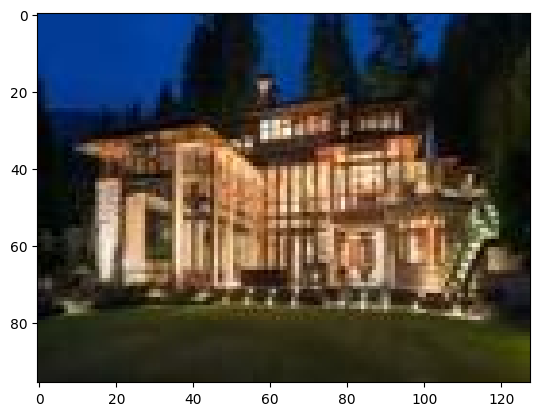

In [109]:
from PIL import Image
import matplotlib.pyplot as plt
image = Image.open(top_image.iloc[0]['image_path'])
plt.imshow(image)
plt.show()